In [2]:
from contextual_bandit import ContextualBandit
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from Fusion_Model import FusionModel, LSTM
import json
import matplotlib.pyplot as plt
from CenterLoss import CenterLoss, FocalLoss
from torch.utils.data import DataLoader, TensorDataset
from imblearn.under_sampling import NearMiss

In [3]:
def get_dataloaders(X, y, batch_size=None):
    dataset = TensorDataset(X, y)
    if batch_size is None:
        dataloader = DataLoader(dataset, batch_size=X.shape[0], shuffle=True)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [8]:
X_train = pd.read_csv('data/X_train.csv')
y_train = torch.load('data/y_train.pt')

In [9]:
X_train['employee embedding'] = X_train['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
X_train['company embedding'] = X_train['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
employee = torch.tensor(np.vstack(X_train['employee embedding'].values), dtype=torch.float64)
company = torch.tensor(np.vstack(X_train['company embedding'].values), dtype=torch.float64)

In [10]:
combined_tensor = torch.concat((employee, company), axis = 1)
combined_tensor.shape

torch.Size([29273, 64])

In [11]:
undersample = NearMiss(version=1, n_neighbors=3)
X_undersampled, y_undersampled = undersample.fit_resample(np.array(combined_tensor), y_train)

In [12]:
X_undersampled = torch.tensor(X_undersampled)

In [13]:
y_undersampled = torch.tensor(y_undersampled)
torch.save(X_undersampled, 'data/X_train_b.pt')
torch.save(y_undersampled, 'data/y_b.pt')

In [8]:
encoding_map = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
    }

datas = []

for i in range(4):
    encoding_map[i] = 1
    yi = np.array([encoding_map[category] for category in y_undersampled])
    yi = torch.tensor(yi)
    datas.append(get_dataloaders(X_undersampled, yi, batch_size=64))
    encoding_map[i] = 0

In [43]:
criterions = [nn.CrossEntropyLoss() for _ in range(4)]
bandit = ContextualBandit(4, 64, criterions, 50)

In [44]:
bandit.initialize(datas)

Final loss:  0.2903859615325928
F1 score:  0.7694013303769403
Final loss:  0.24662424623966217
F1 score:  0.8270509977827052
Final loss:  0.11330176144838333
F1 score:  0.9720880300590445
Final loss:  0.054747506976127625
F1 score:  1.0


In [14]:
X_test = torch.load('data/X_test_simple.pt')
y_test = torch.load('data/y_test.pt')

In [46]:
test_loader = get_dataloaders(X_test, y_test, batch_size = 1)
preds = []

for batch in test_loader:
    X, _ = batch
    preds.append(bandit.select_arm(X))

In [47]:
pd.Series(preds).value_counts()

2    2775
3    2111
0    1706
1     735
Name: count, dtype: int64

([<matplotlib.axis.YTick at 0x1ac24add0>,
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2'), Text(0, 3.5, '3')])

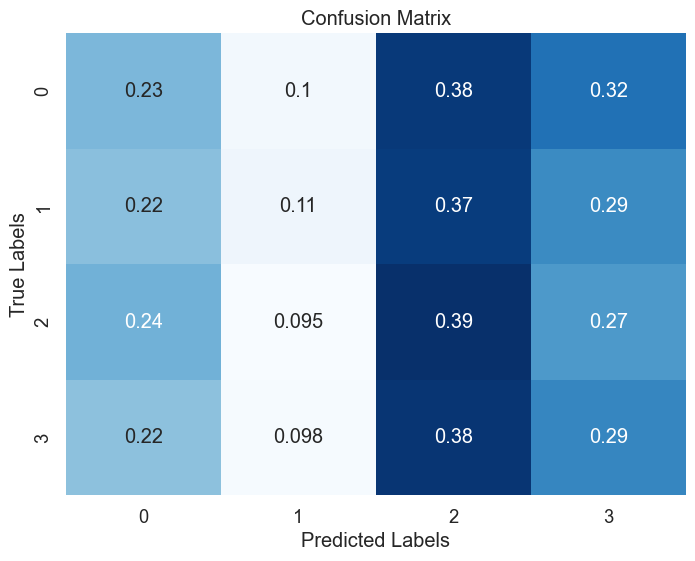

In [48]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, preds)

conf_matrix = conf_matrix.astype(float) 
conf_matrix /= np.sum(conf_matrix, axis = 1)
conf_matrix.diagonal()

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability

# Create heatmap
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False)

# Set labels, title, and axis ticks
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(conf_matrix))+0.5, labels=np.arange(len(conf_matrix)))
plt.yticks(ticks=np.arange(len(conf_matrix))+0.5, labels=np.arange(len(conf_matrix)))

In [49]:
f1_score(y_test, preds, average = 'macro')

0.24372485867148025

In [50]:
example = pd.read_csv('data/submission_example.csv')
example.head()

,Unnamed: 0,id,position
0,0,29273,Manager
1,1,29274,Assistant
2,2,29275,Executive
3,3,29276,Manager
4,4,29277,Manager


In [16]:
y_train_arr = np.array([encoding_map[category.item()] for category in y_train])
y_train_arr = torch.tensor(y_train_arr)
y_test_arr = np.array([encoding_map[category.item()] for category in y_test])
y_test_arr = torch.tensor(y_test_arr)

In [17]:
pd.Series(y_train_arr).value_counts()

0    29273
Name: count, dtype: int64

In [18]:
torch.save(y_train_arr, 'data/y_train_binary.pt')
torch.save(y_train_arr, 'data/y_test_binary.pt')

In [19]:
y_train_df = pd.read_csv('data/y_train.csv')
pd.Series(y_train_df['position']).value_counts()

position
Executive    17793
Assistant     9023
Director      1356
Manager       1101
Name: count, dtype: int64

In [20]:
def get_data(pathX, pathy, batch_size = None):
    X_df = pd.read_csv(pathX, index_col=0)
    X_df['employee embedding'] = X_df['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
    X_df['company embedding'] = X_df['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
    employee = torch.tensor(np.vstack(X_df['employee embedding'].values), dtype=torch.float64)
    company = torch.tensor(np.vstack(X_df['company embedding'].values), dtype=torch.float64)
    LSTM_X = torch.zeros(employee.shape[0], 2, employee.shape[1])
    LSTM_X[:, 0, :] = employee
    LSTM_X[:, 1, :] = company
    y = torch.load(pathy)
    return get_dataloaders(LSTM_X, y,batch_size)

In [21]:
test_dataloader = get_data('data/X_test.csv', 'data/y_test.pt')

In [22]:
X_train_df, y_train = pd.read_csv('data/X_train.csv', index_col = 0), pd.read_csv('data/y_train.csv', index_col=0)
X_train_df['employee embedding'] = X_train_df['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
X_train_df['company embedding'] = X_train_df['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
X_train_df.iloc[:, 1:].values.shape
employee_embedding_tensor = torch.tensor(np.vstack(X_train_df['employee embedding'].values), dtype=torch.float64)
company_embedding_tensor = torch.tensor(np.vstack(X_train_df['company embedding'].values), dtype=torch.float64)
LSTM_X = torch.zeros(employee_embedding_tensor.shape[0], 2, 32)
LSTM_X[:, 0, :] = employee_embedding_tensor
LSTM_X[:, 1, :] = company_embedding_tensor
y_train = torch.load('data/y_train.pt')

In [23]:
y_train = pd.Series(y_train)
mask1 = y_train[y_train == 1].index
mask0 = y_train[y_train == 0].index

In [24]:
pd.Series(y_train).value_counts()

1.0    17793
0.0     9023
3.0     1356
2.0     1101
Name: count, dtype: int64

In [25]:
label0 = X_train_df.iloc[mask1, :].sample(878)
label0.shape

(878, 3)

In [26]:
label1 = X_train_df.iloc[mask0, :].sample(878)

In [27]:
mask2 = y_train[y_train == 2].index
mask3 = y_train[y_train == 3].index
label2 = X_train_df.iloc[mask2, :]
label3 = X_train_df.iloc[mask3, :]
X_balanced = pd.concat([label0, label1, label2, label3])
X_balanced.shape

(4213, 3)

In [28]:
X_balanced.index

Index([ 5322,  9541, 11844, 26860,  8650, 28590, 24869, 12734, 25375, 12188,
       ...
       29088, 29089, 29104, 29121, 29175, 29207, 29208, 29209, 29210, 29227],
      dtype='int64', length=4213)

In [29]:
y_train_df.shape

(29273, 3)

In [30]:
X_train_df.shape

(29273, 3)

In [31]:
y_train_balanced = y_train_df.loc[y_train_df['id'].isin(X_balanced['id']), :]

In [32]:
y_train_balanced.shape[0] == X_balanced.shape[0]

True

In [33]:
employee_embedding_tensor = torch.tensor(np.vstack(X_balanced['employee embedding'].values), dtype=torch.float64)
company_embedding_tensor = torch.tensor(np.vstack(X_balanced['company embedding'].values), dtype=torch.float64)
LSTM_X_b = torch.zeros(employee_embedding_tensor.shape[0], 2, 32)
LSTM_X_b[:, 0, :] = employee_embedding_tensor
LSTM_X_b[:, 1, :] = company_embedding_tensor
LSTM_X_b.shape

torch.Size([4213, 2, 32])

In [34]:
y_train_balanced = y_train_balanced['position']

In [35]:
LSTM_X_b.shape, y_train_balanced.shape

(torch.Size([4213, 2, 32]), (4213,))

In [36]:
encoding_map = {
        "Assistant": 0,
        "Executive": 1,
        "Manager": 2,
        "Director": 3,
    }
y_train_arr = np.array([encoding_map[category] for category in y_train_balanced])
y_train_arr = torch.tensor(y_train_arr)

In [37]:
pd.Series(y_train_arr).value_counts()

3    1356
2    1101
1     878
0     878
Name: count, dtype: int64

In [38]:
train_balanced = get_dataloaders(LSTM_X_b, y_train_arr, 64)

In [39]:
employee_embedding_tensor = torch.tensor(np.vstack(X_train_df['employee embedding'].values), dtype=torch.float64)
company_embedding_tensor = torch.tensor(np.vstack(X_train_df['company embedding'].values), dtype=torch.float64)
LSTM_X = torch.zeros(employee_embedding_tensor.shape[0], 2, 32)
LSTM_X[:, 0, :] = employee_embedding_tensor
LSTM_X[:, 1, :] = company_embedding_tensor


In [40]:
# cutoff = int(LSTM_X_b.shape[0]*0.7)
# X_train_balanced, y_train_balanced = LSTM_X_b[:cutoff, :, :], y_train[:cutoff]
# X_val_balanced, y_val_balanced = LSTM_X_b[cutoff:, :, :], y_train[cutoff:]


In [41]:
cutoff = int(LSTM_X.shape[0]*0.7)
LSTM_X_train, y_train1 = LSTM_X[:cutoff, :, :], y_train[:cutoff]
LSTM_X_val, y_val = LSTM_X[cutoff:, :, :], y_train[cutoff:]
y_train = y_train1

In [42]:
data1 = LSTM_X_train
val1 = LSTM_X_val
y1 = y_train == 0
y1_val = y_val == 0

train1, val1 = get_dataloaders(data1, y1, 64), get_dataloaders(val1, y1_val)

TypeError: 'int' object is not callable

In [ ]:
pd.Series(y1).value_counts() / len(y1)

False    0.709873
True     0.290127
Name: count, dtype: float64

In [ ]:
def train(epochs, lr, train_data, model, criterion):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    losses = []
    f1_scores = []
    # train_val, val_y = next(iter(val_data)) # assumes only 1 batch in training data
    model.train()
    # prev_F1 = 0
    for epoch in tqdm(range(epochs)):
        running_loss = []
        running_f1 = []
        for batch in train_data:
            X,y = batch
            emb = model(X).squeeze(1)
            emb = torch.clamp(emb, 0, 4)
            preds = torch.argmax(emb, dim = 1)
            f1_score_epoch = f1_score(y, preds, average='macro')
            optimizer.zero_grad()
            loss = criterion(emb, y.long())
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
            running_f1.append(f1_score_epoch)
        losses.append(np.mean(running_loss))
        f1_scores.append(np.mean(running_f1))
        if epoch % 10 == 0:
            # val_probs = model(train_val)
            # val_preds = torch.argmax(val_probs, dim = 1)
            # val_f1 = f1_score(val_y, val_preds, average = 'macro')
            # if val_f1 < prev_F1:
            #     print('early stopping')
            #     model.eval()
            #     return losses, f1_scores
            # else:
            #     print('Val F1 score: ', val_f1)
            print('Train loss: ', losses[-1])
            print('F1 score: ', f1_scores[-1])
                # prev_F1 = val_f1
    model.eval()
    return losses

In [ ]:
# weights = torch.tensor([0.3, 0.7]).float()
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
model1 = LSTM(2, 32, 128, 4)
losses = train(50, 1e-3, train1, model1, criterion)

  2%|▏         | 1/50 [00:04<03:16,  4.01s/it]

Train loss:  0.6931473013025207
F1 score:  0.4143901987388366


 22%|██▏       | 11/50 [00:41<02:27,  3.79s/it]

Train loss:  0.6931473013025207
F1 score:  0.4144746267513342


 42%|████▏     | 21/50 [01:19<01:46,  3.67s/it]

Train loss:  0.6931473013025207
F1 score:  0.4142752978898153


 62%|██████▏   | 31/50 [01:57<01:11,  3.74s/it]

Train loss:  0.6931473013025207
F1 score:  0.4146399285503746


 82%|████████▏ | 41/50 [02:36<00:35,  3.91s/it]

Train loss:  0.6931473013025207
F1 score:  0.4144458057573443


100%|██████████| 50/50 [03:10<00:00,  3.82s/it]


In [ ]:
y_test = torch.load('data/y_test.pt')
preds = torch.argmax(model1(next(iter(test_dataloader))[0]), dim=1)
f1_score(y_test, preds, average ='macro')

0.10218264741014227

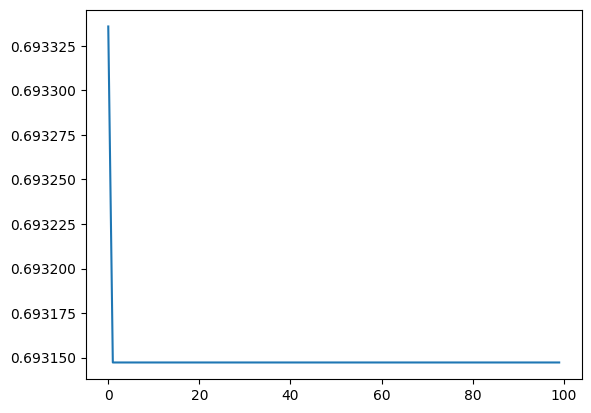

In [ ]:
plt.plot(losses)

In [ ]:
for X,y in dataloader:
    lstm_only()

In [ ]:
LSTM_X_test, LSTM_y_test = next(iter(test_dataloader))
probs = lstm_only(LSTM_X_test)
preds = torch.argmax(probs, dim=1)
f1_score(LSTM_y_test, preds, average = 'macro')

0.17754621406804985

In [ ]:
np.sum(conf_matrix, axis = 1)

array([1882, 1812, 1818, 1815])

In [ ]:
conf_matrix.astype(float)

array([[ 436., 1312.,   79.,   55.],
       [ 390., 1291.,   76.,   55.],
       [ 391., 1281.,   78.,   68.],
       [ 432., 1242.,   83.,   58.]])

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(LSTM_y_test, preds)

conf_matrix = conf_matrix.astype(float) 
conf_matrix /= np.sum(conf_matrix, axis = 1)
conf_matrix.diagonal()

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability

# Create heatmap
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False)

# Set labels, title, and axis ticks
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(conf_matrix))+0.5, labels=np.arange(len(conf_matrix)))
plt.yticks(ticks=np.arange(len(conf_matrix))+0.5, labels=np.arange(len(conf_matrix)))

array([0.22316684, 0.73565121, 0.02420242, 0.02809917])

([<matplotlib.axis.YTick at 0x1a0dc9cd0>,
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2'), Text(0, 3.5, '3')])

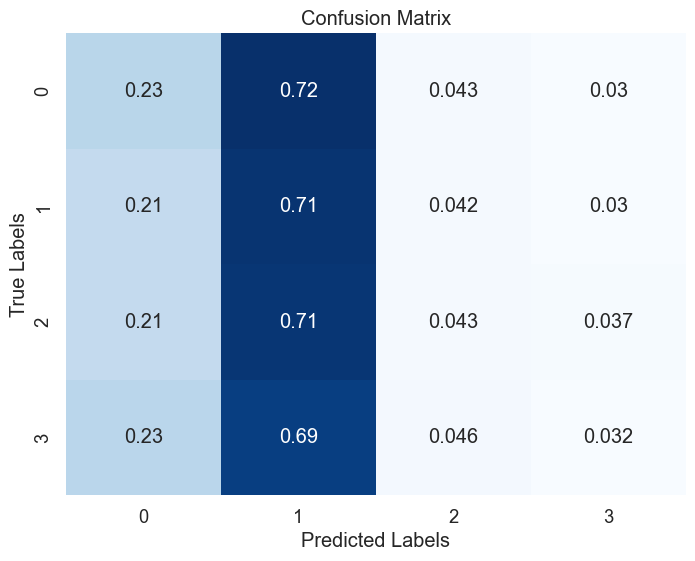

In [ ]:
pd.Series(y_train).value_counts()

1.0    12840
0.0     5945
2.0      878
3.0      828
Name: count, dtype: int64

In [ ]:
losses[-1]

0.01109021907435117

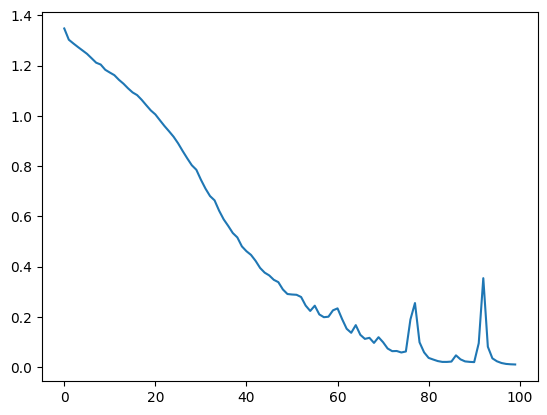

In [ ]:
plt.plot(losses)

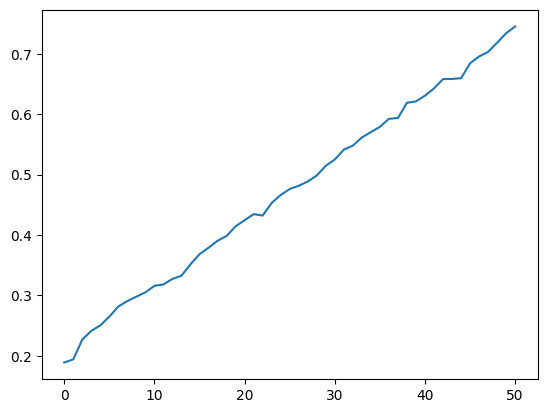

In [ ]:
plt.plot(F1_scores)

In [ ]:
predictions = []
for batch in val_dataloader:
    X, y = batch
    preds = lstm_only(X)
    preds = torch.round(preds)
    preds = preds.int()
    predictions.append(preds)


In [ ]:
y_pred = torch.tensor(np.array(predictions))[0, :, 0]

In [ ]:
y_val.shape == y_pred.shape

True

In [ ]:
f1_score(y_pred, y_val, average = 'macro')

0.06760809121881456

In [ ]:
new_preds = []

for lst in predictions:
    for a in lst:
        new_preds.append(a.item())

In [ ]:
len(new_preds), y_train.shape

(29273, (29273, 2))

In [ ]:
f1_score(y_train, new_preds, average = 'macro')

0.25057272321093

In [ ]:
y_train

tensor([1., 1., 1.,  ..., 1., 1., 1.])